# Heatmap plots over LLM scraped data

Anton Antonov   
[RakuForPrediction at WordPress](https://rakuforprediction.wordpress.com)   
[RakuForPrediction-book at GitHub](https://github.com/antononcube/RakuForPrediction-book)    
December 2023   
January 2024

------

## Introduction

In this document we show the use of Artificial Intelligence (AI) Vision and Large Language Models (LLMs) for data scraping from images and Web pages and and we present heatmap plots corresponding to the scraped data. 

The LLM utilization and visualization are done in chat-enabled Jupyter notebook with a Raku kernel; "chatbook" for short. 
See ["Jupyter::Chatbook"](https://raku.land/zef:antononcube/Jupyter::Chatbook), [AAp4, AAv3].

The heatmap plots in the Jupyter notebook are done with the package ["JavaScript::D3"](https://raku.land/zef:antononcube/JavaScript::D3), [AAp8, AAv1, AAv2]. (Heatmap plots were recently implemented.)

We use data from sites dedicated of tracking Russian and Ukrainian casualties in NATO's war in Ukraine, (2022-present):

- Russian casualties: [Mediazona](https://en.zona.media/article/2022/05/20/casualties_eng), [MZ1]
- Ukrainian casualties: [UALosses](https://ualosses.org/), [UAL1]

**Remark:** Note that UALosses is relatively new, hence it provides too few records of Ukrainian losses. The casualties of Medizona and UALosses should be considered underestimates because of the methodologies they use. (Tracking and verifying online records.) See:
- Section ["Our methods"](https://en.zona.media/article/2022/05/20/casualties_eng) of Mediazona
- Page ["About the project"](https://ualosses.org/about/) of UALosses 

This document is a complement to the document ["Extracting Russian casualties in Ukraine data from Mediazona publications"](https://mathematicaforprediction.wordpress.com/2023/12/15/extracting-russian-casualties-in-ukraine-data-from-mediazona-publications), [AA4], 
and it uses AI Vision and LLM functionalities described in [AA1-AA3].

### Outline

Here is an outline of the workflow steps shown below:

1. Setup (packages and JavaScript plotting)
2. Get a screenshot of Russian casualties heatmap plot from [Mediazona](https://en.zona.media/article/2022/05/20/casualties_eng), [MZ1]
3. Using OpenAI's AI Vision extract data from the screenshot
4. Verify and manually adjust the obtained data 
5. Make a heatmap plot
6. Verify the plotted data
7. Download page with regional Ukrainian casualties from [UALosses](https://ualosses.org/regions/), [UAL1]
8. Use LLM to obtain the tabular data for those casualties 
9. Adjust, translate, or match names of regions (via LLMs)
10. Make the corresponding heatmap plot
11. Observations and conclusions   


-------

## Setup

In this section we load the necessary packages and setup chatbook's environment for Javascript plots.

In [1]:
use JSON::Fast;
use HTTP::Tiny;

use Data::Generators;
use Data::Reshapers;
use Data::Summarizers;

use JavaScript::D3;

In [2]:
%% javascript
require.config({
     paths: {
     d3: 'https://d3js.org/d3.v7.min'
}});

require(['d3'], function(d3) {
     console.log(d3);
});

In [3]:
#%js
js-d3-list-line-plot((^40).roll(120), background => '#282828', color => 'orange')

-----

## Heatmap screenshot import

Here we get a screenshot image from [AAr1, MZ1] of the Russian casualties and we import it into the chatbook's session: 

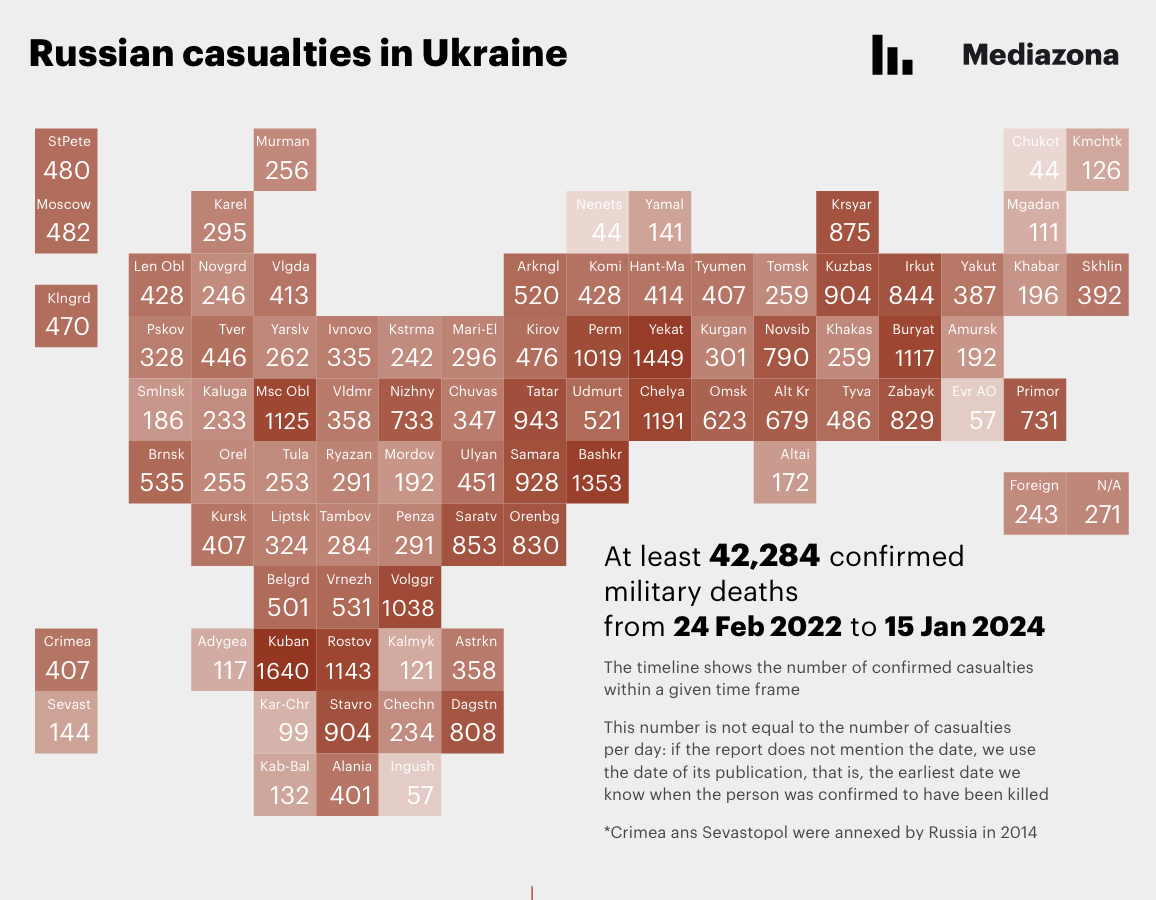

In [2]:
#% markdown
my $url = 'https://raw.githubusercontent.com/antononcube/SystemModeling/master/Projects/War-modeling/Diagrams/Mediazona-Russian-casualties-choropleth-upto-2024-01-19.png';
my $img = image-import($url);

**Remark:** The function `image-import` is from the package ["Image::Markup::Utilities"](https://raku.land/zef:antononcube/Image::Markup::Utilities), [AAp5], which is automatically loaded in a notebook session of ["Jupyter::Chatbook"](https://raku.land/zef:antononcube/Jupyter::Chatbook), [AAp4].

------

## Data extraction via AI Vision

Here we extract the data from imported screenshot using the function `llm-vision-synthesize`, [AAp1, AAp2, AA3]:

In [4]:
llm-vision-synthesize("Give row-wise the Russian states and numbers in the squares of the choropleth.", $url, max-tokens => 2000)

The image contains a lot of text and numbers, which appear to be related to Russian casualties in Ukraine, categorized by different Russian states. I'll provide the information row-wise as requested:

First row:
- StPete: 480
- Moscow: 482
- Klng: 470

Second row:
- Murman: 256
- Karel: 295
- Len Obl: 428
- Novgrd: 246
- Vlgda: 413
- Arkngl: 520
- Komi: 414
- Hant-Ma: 407
- Tyumen: 259
- Tomsk: 904
- Kuzbas: 259
- Irkut: 844
- Yakut: 387
- Khabar: 196
- Chukot: 44
- Kmchtk: 126

Third row:
- Pskov: 328
- Tver: 446
- Yarslv: 262
- Ivonvo: 335
- Kstrma: 242
- Mari-El: 296
- Kirov: 476
- Perm: 1019
- Yekat: 1449
- Kurgan: 301
- Novsib: 790
- Khakas: 259
- Buryat: 1117
- Amursk: 192
- Mgadan: 111

Fourth row:
- Smlnsk: 186
- Kaluga: 233
- Msc Obl: 1125
- Vldmr: 358
- Nizhny: 733
- Chuvas: 347
- Tatar: 943
- Udmurt: 521
- Chelya: 1191
- Omsk: 623
- Alt Kr: 679
- Tyva: 486
- Zabayk: 829
- Evr AO: 57
- Primor: 731

Fifth row:
- Brnsk: 535
- Orel: 255
- Tula: 253
- Ryazan: 292
- Mordov: 191
- 

The result we get has the data from the screenshot, but in order to make a heatmap plot we would benefit from a more structured data representation that reflects the Geo-inspired structure of the choropleth. 

Here is we prepare and use a more detailed and instructive prompt and combine it with:
- JSON only prompt from ["LLM::Prompts"](https://raku.land/zef:antononcube/LLM::Prompts), [AAp3]
- JSON sub-parser from ["Text::SubParsers"](https://raku.land/zef:antononcube/Text::SubParsers), [AAp6]

In [21]:
my $p = q:to/END/;
The image has boxes arranged in jagged array. 
The full array would have been with 11 rows and 17 columns. 
Give a JSON dictionary of the content of the boxes in the image. 
The keys should be matrix coordinates, the values are two element lists corresponding to the labels inside the boxes.
END

my $res = llm-vision-synthesize([$p, llm-prompt("NothingElse")("JSON")], $url, max-tokens => 2000, form => sub-parser('JSON'):drop)

[[9,1] => [Alania 401] [3,2] => [Msc Obl 1125] [1,3] => [Vlgda 413] [8,4] => [Dagstn 808] [0,7] => [Chukot 44] [0,1] => [Murm 256] [2,9] => [Kurgan 301] [3,4] => [Nizhny 733] [7,4] => [Kalmyk 121] [5,2] => [Tambov 284] [2,5] => [Mari-El 296] [4,3] => [Ryazan 291] [1,8] => [Tomsk 259] [3,0] => [Smlnsk 186] [3,13] => [Evr AO 57] [2,13] => [Amursk 192] [2,12] => [Buryat 1117] [6,2] => [Volggr 1038] [3,10] => [Alt Kr 679] [2,10] => [Novsib 790] [1,13] => [Skhlin 392] [9,0] => [Kab-Bal 132] [1,2] => [Novgrd 246] [0,9] => [Mgdan 111] [8,1] => [Kar-Chr 99] [4,5] => [Ulyan 451] [0,3] => [Karel 295] [1,9] => [Kuzbas 904] [2,3] => [Ivnovo 335] [7,0] => [Crimea 407] [0,5] => [Yamal 141] [4,0] => [Brnsk 535] [1,0] => [Klngrd 470] [5,0] => [Kursk 407] [3,1] => [Kaluga 233] [4,7] => [Bashkr 1353] [1,4] => [Arkngl 520] [2,0] => [Pskov 328] [5,5] => [Orenbg 830] [1,10] => [Irkut 844] [4,2] => [Tula 253] [8,3] => [Chechn 234] [2,7] => [Perm 1019] [4,8] => [Altai 172] [5,1] => [Lipstk 324] [3,7] => [Udm

**Remark:** Again, the packages "LLM::Prompts", "Text::SubParsers" are automatically loaded in a chatbook session.

In order to explore the obtained data further we inform ourselves about its structure: 

In [22]:
deduce-type($res)

Vector(Pair(Atom((Str)), Vector(Atom((Str)), 2)), 87)

**Remark:** The function `deduce-type` is from the package ["Data::TypeSystem"](https://raku.land/zef:antononcube/Data::TypeSystem), [AAp7], which is automatically loaded in a chatbook session. "Data::TypeSystem" is used other data-transformation packages, and, in "JavaScript::D3", [AAp8], used for the heatmaps below.

From the deduced type result we see that the structure corresponds to what we specified in the prompt -- a list of pairs. 
But the JSON conversion from the sub-parser gives:
- Keys that are not two-element lists of coodinates, but (corresponding) strings
- Values that are lists of two strings (instead of a string and a number)

Here the data above is transformed into a dataset (a list of hash-maps):

In [23]:
my @ds3D = $res.map({ <y x z label>.Array Z=> [ |from-json($_.key), $_.value[1].Int, $_.value ].flat })>>.Hash;
say dimensions(@ds3D);
say deduce-type(@ds3D);

(87 4)
Vector(Struct([label, x, y, z], [Array, Int, Int, Int]), 87)


Using that dataset we can overview the extracted data in the corresponding choropleth (or heatmap plot):

In [ ]:
#%js
js-d3-heatmap-plot(@ds3D, width => 1200, plot-labels-font-size =>10)

We can see that the vertical orientation is inverted. We got matrix coordinates, i.e. row indexes are ordered top-bottom. 
We are given heatmap plot bottom-top.

----

## Manual data adjustment

In this section we adjust extracted data in order to produce a heatmap that corresponds to that of Midiazona.
We also, opportunistically, verify the data results. (Correct AI Vision recognition of text and numbers should be both trusted and verified.)

Here is the manual adjustment of the data (placed into a new data structure):

In [4]:
my %locCas = (
   (1, 1) => ["StPete", 480], (1, 4) => ["Murman", 256], (1, 16) => ["Chukot", 44], (1, 17) => ["Kmchtk", 126],
   (2, 1) => ["Moscow", 482], (2, 3) => ["Karel", 295], (2, 8) => ["Nenets", 44], (2, 9) => ["Yamal", 141], (2, 12) => ["Krsyar", 875], (2, 16) => ["Mgadan", 111],
   
   (3, 2) => ["Len Obl", 428], (3, 3) => ["Novgrd", 246], (3, 4) => ["Vlgda", 413], (3, 8) => ["Arkngl", 520], (3, 9) => ["Komi", 428], (3, 10) => ["Hant-Ma", 414], (3, 11) => ["Tyumen", 407], (3, 12) => ["Tomsk", 259], (3, 13) => ["Kuzbas", 904], (3, 14) => ["Irkut", 844],
   (3, 15) => ["Yakut", 387], (3, 16) => ["Khabar", 196], (3, 17) => ["Skhlin", 392],
   
   (4, 1) => ["Klngd", 470], (4, 2) => ["Pskov", 328], (4, 3) => ["Tver", 446], (4, 4) => ["Yarslv", 262], (4, 5) => ["Ivnovo", 335], (4, 6) => ["Kstrma", 242], (4, 7) => ["Mari-El", 296], (4, 8) => ["Kirov", 476], (4, 9) => ["Perm", 1019], (4, 10) => ["Yekat", 1449], (4, 11) => ["Kurgan", 301], (4, 12) => ["Novsib", 790], (4, 13) => ["Khakas", 259],
   (4, 14) => ["Buryat", 1117], (4, 15) => ["Amursk", 192],
   
   (5, 2) => ["Smlnsk", 186], (5, 3) => ["Kaluga", 233], (5, 4) => ["Msc Obl", 1125], (5, 5) => ["Vldmr", 358], (5, 6) => ["Nzhny", 733], (5, 7) => ["Chuvas", 347], (5, 8) => ["Tatar", 943], (5, 9) => ["Udmurt", 521], (5, 10) => ["Chelya", 1191], (5, 11) => ["Omsk", 623], (5, 12) => ["Alt Kr", 679],
   (5, 13) => ["Tyva", 486], (5, 14) => ["Zabayk", 829], (5, 15) => ["Ev AO", 57], (5, 16) => ["Primor", 731],
   
   (6, 2) => ["Brnsk", 535], (6, 3) => ["Orel", 255], (6, 4) => ["Tula", 253], (6, 5) => ["Ryazan", 291], (6, 6) => ["Mordov", 192], (6, 7) => ["Ulyan", 451],
   (6, 8) => ["Samara", 928], (6, 9) => ["Bashkr", 1353], (6, 12) => ["Altai", 172],
   
   (7, 3) => ["Kursk", 407], (7, 4) => ["Liptsk", 324], (7, 5) => ["Tambov", 284], (7, 6) => ["Penza", 291], (7, 7) => ["Saratv", 853], (7, 8) => ["Orenbg", 830],
   
   (8, 4) => ["Belgrd", 501], (8, 5) => ["Vrnzeh", 531], (8, 6) => ["Volggr", 1038],
   
   (9, 1) => ["Crimea", 407], (9, 3) => ["Adygea", 117], (9, 4) => ["Kuban", 1640], (9, 5) => ["Rostov", 1143], (9, 6) => ["Kalmyk", 121], (9, 7) => ["Astrkn", 358],
   
   (10, 1) => ["Sevast", 144], (10, 4) => ["Kar-Chr", 99], (10, 5) => ["Stavro", 904], (10, 6) => ["Chechn", 234], (10, 7) => ["Dagstn", 808],
   
   (11, 4) => ["Kab-Bal", 132], (11, 5) => ["Alania", 401], (11, 6) => ["Ingush", 57],
   
   (10, 16) => ["Foreign", 243], (10, 17) => ["N/A", 271]
);

say "No of records    : {%locCas.elems}";
say "Total casualties : {%locCas.values.map(*[1]).sum}";
say deduce-type(%locCas);

No of records    : 87
Total casualties : 42284
Assoc(Atom((Str)), Tuple([Atom((Str)), Atom((Int))]), 87)


**Remark:** The total number of casualties from the data structure is the same as in the screenshot from Mediazona above.

-------

## Heatmap plot

Here we transform the data into a dataset and show the data type:

In [5]:
my @ds3D = %locCas.map({ <y x z label>.Array Z=> [ |$_.key.split(/\h/)>>.Int, $_.value[1], $_.value ].flat })>>.Hash;
say @ds3D.elems;
say deduce-type(@ds3D);

87
Vector(Struct([label, x, y, z], [Array, Int, Int, Int]), 87)


Here is the corresponding summary:

In [6]:
sink records-summary(select-columns(@ds3D, <x y z>))

+--------------------+--------------------+----------------------+
| x                  | y                  | z                    |
+--------------------+--------------------+----------------------+
| Min    => 1        | Min    => 1        | Min    => 44         |
| 1st-Qu => 4        | 1st-Qu => 3        | 1st-Qu => 246        |
| Mean   => 7.781609 | Mean   => 5.367816 | Mean   => 486.022989 |
| Median => 7        | Median => 5        | Median => 401        |
| 3rd-Qu => 12       | 3rd-Qu => 7        | 3rd-Qu => 731        |
| Max    => 17       | Max    => 11       | Max    => 1640       |
+--------------------+--------------------+----------------------+


Here we transform the dataset to have:
- Two-row labels
- Separation gap for "odd" regions (Moscow, Crimea, etc.)
- Casualty values that are suitably rescaled for more informative visualization

In [7]:
my @ds3D2 = @ds3D>>.clone.map({ $_<z> = sqrt($_<z>); $_<x> = $_<x> > 1 ?? $_<x> + 1 !! $_<x> ; $_<y> = 12 - $_<y>; $_<label> = "<tspan>{$_<label>.head}</tspan><tspan dx='-{$_<label>.head.chars/2}em', dy='1em'>{$_<label>.tail}</tspan>"; $_ });
@ds3D2.elems

87

Here is the heatmap plot:

In [10]:
#%js
js-d3-heatmap-plot(@ds3D2, width => 1100, height => 800,
    x-tick-labels => (1..18),
    plot-labels-font-size => 13,
    plot-labels-color => 'white', 
    color-palette => 'Reds', 
    background => "#282828", 
    tick-labels-font-size => 0,
    low-value => 0,
    high-value => sqrt(1800),
    mesh => 0.01
)

----

## Additional verifications

We can use LLMs do to some additional verification of the data.
For example, we asks about certain summary statistics over Russia that might increase our confidence in the extracted data.

In [29]:
#% chat, temperature=0.2, model=gpt-4
What are types of the administrative divisions of Russia? 
Answer concisely, only the types and the integer count of the corresponding entities per type.

The administrative divisions of Russia include the following types and their corresponding integer count:

1. Federal subjects: 85
2. Autonomous okrugs: 4
3. Autonomous oblast: 1
4. Federal cities: 3
5. Republics: 22
6. Krais: 9
7. Oblasts: 46

------

## Scrape Ukrainian losses

Here we import the web page of regional Ukrainian losses from ["UALosses"](https://ualosses.org/districts/), [UAL1]:

In [11]:
my $response = HTTP::Tiny.new.get( 'https://ualosses.org/regions/' );
my $htmlRes = $response<content>.decode;
say $htmlRes.chars;


27044


Here we show the table of from the imported page (by HTML applying a regex over its HTML code):

In [12]:
#%html
my $htmlTable = do with $htmlRes ~~ / '<table>' (.*) '</table>' / { $/.Str }

Name 
 Population (2022) 
 Death Count 
 Death Count per Capita 
 Average age at death 
 
 
 
 
 
 
 Kirovohrad Oblast 
 903712 
 1975 
 2.185 per 1000 
 37.5 years 
 View casualties 
 
 View districts 
 View communities 
 
 
 
 
 Zhytomyr Oblast 
 1179032 
 2378 
 2.017 per 1000 
 36.4 years 
 View casualties 
 
 View districts 
 View communities 
 
 
 
 
 Vinnytsia Oblast 
 1509515 
 2871 
 1.902 per 1000 
 37.7 years 
 View casualties 
 
 View districts 
 View communities 
 
 
 
 
 Volyn Oblast 
 1021356 
 1697 
 1.662 per 1000 
 36.8 years 
 View casualties 
 
 View districts 
 View communities 
 
 
 
 
 Rivne Oblast 
 1141784 
 1890 
 1.655 per 1000 
 37.6 years 
 View casualties 
 
 View districts 
 View communities 
 
 
 
 
 Chernihiv Oblast 
 959315 
 1585 
 1.652 per 1000 
 37.1 years 
 View casualties 
 
 View districts 
 View communities 
 
 
 
 
 Khmelnytskyi Oblast 
 1228829 
 1921 
 1.563 per 1000 
 36.4 years 
 View casualties 
 
 View districts 
 View communities 
 
 
 
 
 Sumy Oblast 
 1035772 
 1554 
 1.500 per 1000 
 37.4 years 
 View casualties 
 
 View districts 
 View communities 
 
 
 
 
 Kyiv Oblast 
 1795079 
 2643 
 1.472 per 1000 
 37.7 years 
 View casualties 
 
 View districts 
 View communities 
 
 
 
 
 Cherkasy Oblast 
 1160744 
 1671 
 1.440 per 1000 
 38.1 years 
 View casualties 
 
 View districts 
 View communities 
 
 
 
 
 Poltava Oblast 
 1352283 
 1891 
 1.398 per 1000 
 37.5 years 
 View casualties 
 
 View districts 
 View communities 
 
 
 
 
 Dnipropetrovsk Oblast 
 3096485 
 3930 
 1.269 per 1000 
 37.1 years 
 View casualties 
 
 View districts 
 View communities 
 
 
 
 
 Mykolaiv Oblast 
 1091821 
 1269 
 1.162 per 1000 
 36.1 years 
 View casualties 
 
 View districts 
 View communities 
 
 
 
 
 Chernivtsi Oblast 
 890457 
 1033 
 1.160 per 1000 
 37.7 years 
 View casualties 
 
 View districts 
 View communities 
 
 
 
 
 Ivano-Frankivsk Oblast 
 1351822 
 1564 
 1.157 per 1000 
 38.0 years 
 View casualties 
 
 View districts 
 View communities 
 
 
 
 
 Lviv Oblast 
 2478133 
 2865 
 1.156 per 1000 
 37.5 years 
 View casualties 
 
 View districts 
 View communities 
 
 
 
 
 Ternopil Oblast 
 1021713 
 1123 
 1.099 per 1000 
 37.8 years 
 View casualties 
 
 View districts 
 View communities 
 
 
 
 
 Odesa Oblast 
 2351392 
 1831 
 0.779 per 1000 
 36.1 years 
 View casualties 
 
 View districts 
 View communities 
 
 
 
 
 Kharkiv Oblast 
 2598961 
 1807 
 0.695 per 1000 
 36.3 years 
 View casualties 
 
 View districts 
 View communities 
 
 
 
 
 Zakarpattia Oblast 
 1244476 
 842 
 0.677 per 1000 
 37.1 years 
 View casualties 
 
 View districts 
 View communities 
 
 
 
 
 Kherson Oblast 
 1001598 
 570 
 0.569 per 1000 
 35.4 years 
 View casualties 
 
 View districts 
 View communities 
 
 
 
 
 Zaporizhzhia Oblast 
 1638462 
 792 
 0.483 per 1000 
 36.1 years 
 View casualties 
 
 View districts 
 View communities 
 
 
 
 
 Kyiv 
 2952301 
 977 
 0.331 per 1000 
 37.8 years 
 View casualties 
 
 
 
 
 
 
 
 Donetsk Oblast 
 4059372 
 977 
 0.241 per 1000 
 36.0 years 
 View casualties 
 
 View districts 
 View communities 
 
 
 
 
 Luhansk Oblast 
 2102921 
 383 
 0.182 per 1000 
 34.8 years 
 View casualties 
 
 View districts 
 View communities

The easiest way -- and, maybe, the most reliable way -- to transform that HTML table into a Raku data structure is to use an LLM with a specially crafted prompt.

Here is such an LLM invocation:
- Uses the HTML table obtained above
- Says that only JSON and nothing else should be returned
- Post-process the result with a JSON sub-parser

In [13]:
my $uaRes = llm-synthesize([
    "Convert the HTML table into a Raku list of hashmaps. The values of 'Death Count' and 'Population (2022)' are integers.", 
    $htmlTable, 
    llm-prompt('NothingElse')('JSON')
    ], 
    e => llm-configuration('chatgpt', model => 'gpt-3.5-turbo-16k-0613', max-tokens => 2000), 
    form => sub-parser('JSON'):drop
);

say deduce-type($uaRes);

Vector(Struct([Average age at death, Death Count, Death Count per Capita, Name, Population (2022)], [Str, Int, Str, Str, Int]), 25)


Here we display the obtained data structure as an HTML table:

In [15]:
#% html
my @dsUALosses = |$uaRes;  
@dsUALosses ==> data-translation(field-names=>('Name', 'Population (2022)', 'Death Count', 'Death Count per Capita', 'Average age at death'))

Name,Population (2022),Death Count,Death Count per Capita,Average age at death
Kirovohrad Oblast,903712,1975,2.185 per 1000,37.5 years
Zhytomyr Oblast,1179032,2378,2.017 per 1000,36.4 years
Vinnytsia Oblast,1509515,2871,1.902 per 1000,37.7 years
Volyn Oblast,1021356,1697,1.662 per 1000,36.8 years
Rivne Oblast,1141784,1890,1.655 per 1000,37.6 years
Chernihiv Oblast,959315,1585,1.652 per 1000,37.1 years
Khmelnytskyi Oblast,1228829,1921,1.563 per 1000,36.4 years
Sumy Oblast,1035772,1554,1.500 per 1000,37.4 years
Kyiv Oblast,1795079,2643,1.472 per 1000,37.7 years
Cherkasy Oblast,1160744,1671,1.440 per 1000,38.1 years


The function `data-translation` is from the package ["Data::Translators"](https://raku.land/zef:antononcube/Data::Translators), which is automatically loaded in a chatbook session.

Here is a verification sum:

In [16]:
@dsUALosses.map( *{"Death Count"} ).sum

42039

Here we make a dictionary of region ("oblast") name to casualties:

In [17]:
my %uaOblastCas = @dsUALosses.map({ $_<Name> => $_{"Death Count"} })

{Cherkasy Oblast => 1671, Chernihiv Oblast => 1585, Chernivtsi Oblast => 1033, Dnipropetrovsk Oblast => 3930, Donetsk Oblast => 977, Ivano-Frankivsk Oblast => 1564, Kharkiv Oblast => 1807, Kherson Oblast => 570, Khmelnytskyi Oblast => 1921, Kirovohrad Oblast => 1975, Kyiv => 977, Kyiv Oblast => 2643, Luhansk Oblast => 383, Lviv Oblast => 2865, Mykolaiv Oblast => 1269, Odesa Oblast => 1831, Poltava Oblast => 1891, Rivne Oblast => 1890, Sumy Oblast => 1554, Ternopil Oblast => 1123, Vinnytsia Oblast => 2871, Volyn Oblast => 1697, Zakarpattia Oblast => 842, Zaporizhzhia Oblast => 792, Zhytomyr Oblast => 2378}

-----

## Heatmap Ukraine casualties

Here we prepare choropleth stencil for the Ukrainian losses: 

In [18]:
my %uaLoc = (
    (1, 1) => "Volyn", (1, 2) => "Rivne", (1, 5) => "Chernigov", (1, 6) => "Sumy",
   
    (2, 3) => "Zhitomir", (2, 4) => "Kyiv", (2, 4) => "Kyyivska",

    (3, 1) => "Lviv", (3, 2) => "Ternopil", (3, 3) => "Khmelnytskyi", (3, 5) => "Cherkask", (3, 6) => "Poltava", (3, 7) => "Kharkiv",
    
    (4, 1) => "Ivano-Frankivsk", (4, 3) => "Vinnica", (4, 8) => "Luhansk",
 
    (5, 1) => "Zakarpattia", (5, 2) => "Chernivtsi", (5, 5) => "Kirovohrad", (5, 6) => "Dnipropetrovsk", (5, 7) => "Donetsk",
  
    (6, 5) => "Mykolayivsk", (6, 6) => "Zaporizhzhia",

    (7, 4) => "Odesa", (7, 6) => "Kherson"
);


{1 1 => Volyn, 1 2 => Rivne, 1 5 => Chernigov, 1 6 => Sumy, 2 3 => Zhitomir, 2 4 => Kyyivska, 3 1 => Lviv, 3 2 => Ternopil, 3 3 => Khmelnytskyi, 3 5 => Cherkask, 3 6 => Poltava, 3 7 => Kharkiv, 4 1 => Ivano-Frankivsk, 4 3 => Vinnica, 4 8 => Luhansk, 5 1 => Zakarpattia, 5 2 => Chernivtsi, 5 5 => Kirovohrad, 5 6 => Dnipropetrovsk, 5 7 => Donetsk, 6 5 => Mykolayivsk, 6 6 => Zaporizhzhia, 7 4 => Odesa, 7 6 => Kherson}

Since the stencil was prepared using a Geo-data source different from [ualosses.org](https://ualosses.org/), 
here we formulate and execute an LLM request to make a dictionary that matches the administrative division names 
from the casualties table and stencil:

In [19]:
my %uaOblastNames = llm-synthesize([
    "Match the values of the list:\n {to-json(%uaLoc.values)} \n with the list: \n {to-json(@dsUALosses.map(*<Name>))} \n into a JSON dictionary.",
    llm-prompt('NothingElse')('JSON')
    ], 
    e => llm-configuration('chatgpt', model => 'gpt-3.5-turbo-16k-0613', max-tokens => 2000), 
    form => sub-parser('JSON'):drop
)

{Cherkask => Cherkasy Oblast, Chernigov => Chernihiv Oblast, Chernivtsi => Chernivtsi Oblast, Dnipropetrovsk => Dnipropetrovsk Oblast, Donetsk => Donetsk Oblast, Ivano-Frankivsk => Ivano-Frankivsk Oblast, Kharkiv => Kharkiv Oblast, Kherson => Kherson Oblast, Khmelnytskyi => Khmelnytskyi Oblast, Kirovohrad => Kirovohrad Oblast, Kyyivska => Kyiv Oblast, Luhansk => Luhansk Oblast, Lviv => Lviv Oblast, Mykolayivsk => Mykolaiv Oblast, Odesa => Odesa Oblast, Poltava => Poltava Oblast, Rivne => Rivne Oblast, Sumy => Sumy Oblast, Ternopil => Ternopil Oblast, Vinnica => Vinnytsia Oblast, Volyn => Volyn Oblast, Zakarpattia => Zakarpattia Oblast, Zaporizhzhia => Zaporizhzhia Oblast, Zhitomir => Zhytomyr Oblast}

Here we fill-in the stencil with the casualties numbers:

In [20]:
my %uaLocCas = %uaLoc.map({ $_.key => [$_.value, %uaOblastCas{ %uaOblastNames{$_.value} } // 0] })

{1 1 => [Volyn 1697], 1 2 => [Rivne 1890], 1 5 => [Chernigov 1585], 1 6 => [Sumy 1554], 2 3 => [Zhitomir 2378], 2 4 => [Kyyivska 2643], 3 1 => [Lviv 2865], 3 2 => [Ternopil 1123], 3 3 => [Khmelnytskyi 1921], 3 5 => [Cherkask 1671], 3 6 => [Poltava 1891], 3 7 => [Kharkiv 1807], 4 1 => [Ivano-Frankivsk 1564], 4 3 => [Vinnica 2871], 4 8 => [Luhansk 383], 5 1 => [Zakarpattia 842], 5 2 => [Chernivtsi 1033], 5 5 => [Kirovohrad 1975], 5 6 => [Dnipropetrovsk 3930], 5 7 => [Donetsk 977], 6 5 => [Mykolayivsk 1269], 6 6 => [Zaporizhzhia 792], 7 4 => [Odesa 1831], 7 6 => [Kherson 570]}

Here we convert the hash-map into a dataset (suitable for displaying with "JavaScript::D3"):

In [21]:
my @dsUA3D = %uaLocCas.map({ <y x z label>.Array Z=> [ |$_.key.split(/\h/)>>.Int, $_.value[1], $_.value ].flat })>>.Hash;
say @dsUA3D.elems;
say deduce-type(@dsUA3D);

24
Vector(Struct([label, x, y, z], [Array, Int, Int, Int]), 24)


As with the Russian casualties heatmap plot above, here we transform the Ukrainian losses dataset to have:
- Two-row labels
- Casualty values that are suitably rescaled for more informative visualization

In [22]:
my @dsUA3D2 = @dsUA3D>>.clone.map({ $_<z> = sqrt($_<z>); $_<y> = 12 - $_<y>; $_<label> = "<tspan>{$_<label>.head}</tspan><tspan dx='-{$_<label>.head.chars/2}em', dy='1em'>{$_<label>.tail}</tspan>"; $_ });
@dsUA3D2.elems

24

Here we make the heatmap plot:

In [25]:
#%js
js-d3-heatmap-plot(@dsUA3D2, width => 1000, height => 600,
    x-tick-labels => (1..8),
    plot-labels-font-size => 12,
    plot-labels-color => 'white', 
    color-palette => 'Reds', 
    background => "#282828", 
    tick-labels-font-size => 0,
    low-value => 0,
    high-value => sqrt(1800),
    mesh => 0.01
)

------

## Observation and conclusions

In this section we give several groups of observation and conclusions that came out doing the presented data scraping and plot making.

### Choropleths

- Suitable Geo-data for the choropleth stencils have to be obtained and tweaked.
- Russia 
    - The initial values for the choropleth coordinates were derived via AI Vision.
    - Review and manual adjustment was (of course) required.
    - Since the total number of administration districts is 85, having a set of initial values sped up the final stencil derivation.
- Ukraine 
    - The choropleth stencil coordinates were derived from a Geo plot using Mathematica.
    - Compared to UALosses, Mathematica uses slightly different names of the Ukrainian administrative divisions (or regions.)
- The choropleth stencils could be automatically derived from the actual geometric centers of the administrative divisions, but it seemed easier and less error-prone to make those stencils manually.


### Data scraping

- AI Vision can be effectively used to get data from images in Web pages or other types of documents. See [AA1-AA4] for more details.
- LLMs can be used to convert data elements -- like tables -- of Web pages into programming data structures (that suitable in further computations.)
  - The data conversions we did using LLMs are done "through JSON", because:
    - JSON is a popular well represented data format in LLMs training data
    - Raku has good JSON-to-Raku and Raku-to-JSON converters.
- Small discrepancies or errors from data scraping procedures can be smoothed, detected, or eliminated using LLMs.

### Heatmap plots

- The heatmap plot function `js-d3-heatmap-plot` of "JavaScript:D3" allows:
  - Use of sparse data
  - Rectangles with labels
  - Different color palettes for the values of the rectangles
  - Tunable fonts and colors for axis labels and plot labels
- In order to have two-row labels in the rectangles special HTML-spec has to be used.
  - That is constraint coming up from the implementation of the underlying [Javascript library D3](https://d3js.org).

------

## References

### Articles

[AA1] Anton Antonov,
["AI vision via Raku"](https://rakuforprediction.wordpress.com/2023/11/25/ai-vision-via-raku/),
(2023),
[RakuForPrediction at WordPress](https://rakuforprediction.wordpress.com).

[AA2] Anton Antonov,
["AI vision via Wolfram Language"](https://community.wolfram.com/groups/-/m/t/3072318),
(2023),
[Wolfram Community](https://community.wolfram.com).

[AA3] Anton Antonov,
["Day 24 – Streamlining AI vision workflows"](https://raku-advent.blog/2023/12/24/day-24-streamlining-ai-vision-workflows/),
(2023),
[RakuAdventCalendar at WordPress](https://raku-advent.blog).

[AA4] Anton Antonov,
["Extracting Russian casualties in Ukraine data from Mediazona publications"](https://mathematicaforprediction.wordpress.com/2023/12/15/extracting-russian-casualties-in-ukraine-data-from-mediazona-publications/),
(2023),
[MathematicaForPrediction at WordPress](https://mathematicaforprediction.wordpress.com).

[MZ1] Mediazona, 
[Russian casualties in Ukraine](https://en.zona.media/article/2022/05/20/casualties_eng), 
(2022-2024).

[UAL1] UALosses, 
[Ukrainian losses](https://ualosses.org/), 
(2023-2024).

### Packages, repositories

[AAp1] Anton Antonov,
[WWW::OpenAI](https://github.com/antononcube/Raku-WWW-OpenAI) Raku package,
(2023),
[GitHub/antononcube](https://github.com/antononcube).


[AAp2] Anton Antonov,
[LLM::Functions](https://github.com/antononcube/Raku-LLM-Functions) Raku package,
(2023),
[GitHub/antononcube](https://github.com/antononcube).


[AAp3] Anton Antonov,
[LLM::Prompts](https://github.com/antononcube/Raku-LLM-Prompts) Raku package,
(2023),
[GitHub/antononcube](https://github.com/antononcube).


[AAp4] Anton Antonov,
[Jupyter::Chatbook](https://github.com/antononcube/Raku-Jupyter-Chatbook) Raku package,
(2023),
[GitHub/antononcube](https://github.com/antononcube).


[AAp5] Anton Antonov,
[Image::Markup::Utilities](https://github.com/antononcube/Raku-Image-Markup-Utilities) Raku package,
(2023),
[GitHub/antononcube](https://github.com/antononcube).


[AAp6] Anton Antonov,
[Text::SubParsers](https://github.com/antononcube/Raku-Text-SubParsers) Raku package,
(2023),
[GitHub/antononcube](https://github.com/antononcube).

[AAp7] Anton Antonov,
[Data::TypeSystem](https://github.com/antononcube/Raku-Data-TypeSystem) Raku package,
(2023),
[GitHub/antononcube](https://github.com/antononcube).

[AAp8] Anton Antonov,
[JavaScript::D3](https://github.com/antononcube/Raku-JavaScript-D3) Raku package,
(2022-2023),
[GitHub/antononcube](https://github.com/antononcube).

[AAp9] Anton Antonov,
[Data::Translators](https://github.com/antononcube/Raku-Data-Translators) Raku package,
(2023),
[GitHub/antononcube](https://github.com/antononcube).

[AAr1] Anton Antonov,
[SystemModeling at GitHub](https://github.com/antononcube/SystemModeling),
(2020-2024),
[GitHub/antononcube](https://github.com/antononcube).

### Videos

[AAv1] Anton Antonov,
["The Raku-ju hijack hack for D3.js"](https://www.youtube.com/watch?v=YIhx3FBWayo),
(2022),
[YouTube/@AAA4Prediction](https://www.youtube.com/@AAA4prediction).

[AAv2] Anton Antonov,
["Random mandalas generation (with D3.js via Raku)"](https://www.youtube.com/watch?v=THNnofZEAn4),
(2022),
[YouTube/@AAA4Prediction](https://www.youtube.com/@AAA4prediction).

[AAv3] Anton Antonov,
["Integrating Large Language Models with Raku"](https://www.youtube.com/watch?v=-OxKqRrQvh0),
(2023),
[YouTube/@therakuconference6823](https://www.youtube.com/@therakuconference6823).